### test the quality of the gold stanards of the Ad prompt

In [ ]:
import os
from nltk import tokenize
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import pandas as pd
from sentence_transformers import SentenceTransformer,util
import re


##############################################################################################################`


model = SentenceTransformer('all-mpnet-base-v2', device="cuda")


##############################################################################################################


listStructureWords =  []

dfSrtucturingWords = pd.read_excel("../structureWords.xlsx")

listStructureWords = dfSrtucturingWords.iloc[:,0].tolist()

regex = r"\b(?:{})\b".format("|".join(listStructureWords))
sentences = []

df_fileName = pd.DataFrame({})

for filename in os.listdir(r"D:\UDE\6th Semester\MEMS\MEWS Data\MEWS_Essays\MEWS_Essays\Essays_all\TelevisonMergedT1+T2"):
   with open(os.path.join(r"D:\UDE\6th Semester\MEMS\MEWS Data\MEWS_Essays\MEWS_Essays\Essays_all\TelevisonMergedT1+T2", filename)) as f:
       text = f.read()
       text = text.replace("ï»¿","")
       sents = re.split(regex, text)
       sents = tokenize.sent_tokenize(text)
       for s in sents:
           sentses = tokenize.sent_tokenize(s)
           if (s.isspace() or len(s) ==0):
               continue
           s = s.lower()
           if (len(s.split()) <5):
               continue
           for ss in sentses:
                 if (len(ss.split()) >5):
                     sentences.append(ss)

##############################################################################################################

corpus_embeddings = model.encode(sentences, show_progress_bar =True, device="cuda")

def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

##############################################################################################################


k = 19

clustering, cluster_labels = mbkmeans_clusters(X=corpus_embeddings, k=k, print_silhouette_values=True)

df_clusters = pd.DataFrame({
    "text": sentences,
    "cluster": cluster_labels
})

df_clusters.to_excel("TestClusterReference-WithMultiThreshold-AD.xlsx")

##############################################################################################################


df_test = pd.DataFrame({})

df_ref = pd.read_excel(r"D:\USERS-Load\PycharmProjects\pythonProject\CVS Files\Ads prompt\01.08.22\new Gold standards.xlsx")

def_clusters = pd.read_excel(r"TestClusterReference-WithMultiThreshold-AD.xlsx")

listRef = df_ref['Gold standard']

listClusters = def_clusters['cluster']
listNewSentences = def_clusters['text']
listembReferences = []

for ref in listRef:
    listembReferences.append(model.encode(ref))

allCosinSimiliarityValues = []
allCosinSimiliarity = []
countMissed =[]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]

for emb in corpus_embeddings:
    listMax = []
    for embref in listembReferences:
        cos_sim = util.cos_sim(emb, embref)
        listMax.append(cos_sim)
    index_max = np.argmax(listMax) #this is the right reference cluster
    allCosinSimiliarityValues.append(listMax[index_max])
    allCosinSimiliarity.append(index_max)

for threshold in thresholds:
    mm= 0
    countMissedNumber = 0
    for i in range(0,len(allCosinSimiliarityValues)):
        if (allCosinSimiliarityValues[i] <threshold): #threshold to know if this item does not match any of the references!!!
            countMissedNumber = countMissedNumber +1
            continue
    mm = mm+1
    countMissed.append(countMissedNumber)



In [ ]:
df_test = pd.DataFrame({})
for i in range(0,len(allCosinSimiliarityValues)):
     df_test = df_test.append({
        "ID" : i,
        "text": listNewSentences[i],
        "cluster": listClusters[i],
        "cos Sim": allCosinSimiliarity[i],
        "similarity value": allCosinSimiliarityValues[i][0][0]
              },ignore_index=True)

df_test.to_excel("TestClusterReference-WithMultiThreshold-AD - Threshold - 0.5.xlsx")

In [ ]:
print(countMissed)


### plotting the results in form of a graph

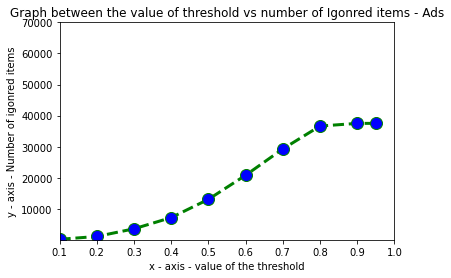

In [3]:
import matplotlib.pyplot as plt

# x axis values
x = thresholds
# corresponding y axis values
y = countMissed

# plotting the points
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)

# setting x and y axis range
plt.xlim(0.1,1)
plt.ylim(50,70000)

# naming the x axis
plt.xlabel('x - axis - value of the threshold')
# naming the y axis
plt.ylabel('y - axis - Number of igonred items')

# giving a title to my graph
plt.title('Graph between the value of threshold vs number of Igonred items - Ads')

# function to show the plot
plt.show()